# 1. Pre-steps

## 1.1 Import the necessary packages

In [335]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
warnings.filterwarnings("ignore")


## 1.2 Import the required dataset

The dataset consists of features computed from a digitized image of a fine needle aspirate(FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. 
The aim is to build a robust classifier that predicts whether the diagnosis is malignant or benign based on the values of the computed features.


In [354]:
df = pd.read_csv("data.csv") 
df = df.drop('Unnamed: 32', axis =1)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 1.3 Create dummies for the dependent variable

This step replaces the two classes of the dependent variable with 1 and 0.

In [355]:
df['diagnosis'].replace('M','1',inplace=True)
df['diagnosis'].replace('B','0',inplace=True)


# 2. Exploratory data analysis


## 2.1 Generate Heatmap

We generate a heatmap to visualize the correlation amongst features.

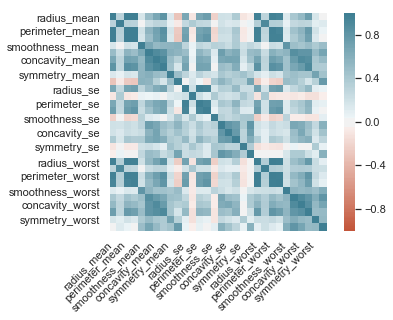

In [356]:
corr_matrix = df.iloc[:,1:].corr()
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## 2.2 Check distribution of classes for the dependent variable

In [357]:
count_malignant = np.sum(df['diagnosis'].astype(int))
count_benign = len(df)-count_malignant
percentage_df = pd.DataFrame()
percentage_df['diagnosis'] = ['Malignant', 'Benign']
percentage_df['percentage(%)'] = [round(count_malignant/len(df)*100,2), round(count_benign/ len(df)*100,2)]
percentage_df.index = percentage_df['diagnosis']
percentage_df = percentage_df.drop(['diagnosis'], axis = 1)
percentage_df

,percentage(%)
diagnosis,
Malignant,37.26
Benign,62.74


# 3. Feature Engineering

From the previous visualization, it is clear that there are a number of highly correlated features.
Now, in order to use a logistic regression classifier, it is necessary that the polynomial function isn't too complex, this may cause the model to overfit. Also, it is always good to exclude the highly correlated predictors, since they don't add any value to the model training. Thus, performing dimensionality reduction is necessary before modelling.

## 3.1 Feature Scaling
The dimensionality reduction technique being used is Principal Component Analysis. Now, since PCA creates principal components by expressing the features as a linear combination, it could happen that features are not at the same scale. It is important to bring the features to the same scale and preserve their distribution otherwise the principal components may appear to be more biased towards 
some features which is undesirable. Thus, the features are transformed to be within a pre-defined range using Min-Max Scaler.

In [358]:
def feature_scaling(data_frame):
    scaler = MinMaxScaler(feature_range=(0,1))
    temp=data_frame.values;
    X=scaler.fit_transform(temp[:,2:data_frame.shape[1]])
    data_frame.iloc[:,2:33]=X
    data_frame.iloc[:,2:33]=X

In [359]:
# Apply Feature Scaling
feature_scaling(df)

## 3.2 Apply dimensionality reduction

PCA is being used to perform dimensionality reduction. Note that we would be choosing only a single principal component because dimensionality reduction is being performed on highly correlated features. Therefore, a single principal component is enough to explain all the variance in the data.
The correlation_threshold is being set as 0.7.

In [360]:
# The function is a wrapper function for the fit and transform method of PCA.
def use_pca(dat):
    pca = PCA(n_components=1)
    pca.fit(dat)
    X_pca = pca.transform(dat)
    return(X_pca)

# The function defined below runs PCA on the highly correlated features and returns a 
# dataset with fewer features, thus reducing the dimensions.

def data_preprocess(df, correlation_threshold = 0.7):
    i=0
    j=1
    component_list=[]
    corr_matrix = df.iloc[:,1:].corr().abs() #find correlation matrix
    for col in corr_matrix:
        if(i<corr_matrix.shape[0]):
            temp=corr_matrix.iloc[i,:];
            component_list.append([corr_matrix.index[list(temp).index(value)] for value in temp if value>correlation_threshold])
            if(int(len(component_list[len(component_list)-1])>1)):            
                selected_df=pd.DataFrame(df[component_list[len(component_list)-1]])
                component=use_pca(selected_df)
                name='new_feature-'+str(j)
                j+=1
                df[name]=component
                for feature in component_list[len(component_list)-1]:
                    df.drop(feature, 1,inplace=True)
                i=0;
            else:
                i+=1
            corr_matrix = df.iloc[:,1:].corr().abs()

In [361]:
initial_df = df.copy(deep = True)
data_preprocess(df, 0.7)
df.head()
print('Number of features initially: {}'.format(initial_df.shape[1]-1))
print('Number of features after the transformation: {}'.format(df.shape[1]-1))

Number of features initially: 31
Number of features after the transformation: 10


In [362]:
df.head()

,id,diagnosis,symmetry_mean,texture_se,smoothness_se,symmetry_se,symmetry_worst,new_feature-2,new_feature-3,new_feature-5,new_feature-8
0,842302,1,0.686364,0.120469,0.159296,0.311645,0.598462,-0.365970,0.278283,0.405728,1.326706
1,842517,1,0.379798,0.082589,0.119387,0.084539,0.233590,-0.079316,-0.109951,-0.083618,0.545463
2,84300903,1,0.509596,0.094303,0.150831,0.205690,0.403706,0.040787,0.136925,-0.033183,0.930401
3,84348301,1,0.776263,0.175875,0.251453,0.728148,1.000000,0.040806,0.659514,0.934063,0.657231
4,84358402,1,0.378283,0.093065,0.332359,0.136179,0.157500,-0.290840,0.048198,-0.095093,0.718764


# 4. Model Performance Evaluation

## 4.1 Train-test split
An 80:20 split is being performed.

In [363]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,2:], df['diagnosis'], train_size = .8)

## 4.2 Fit a classifier and perform predictions
The classifier being used is Logistic Regression.

In [364]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred=logisticRegr.predict(X_test)

## 4.3 Evaluate the model 

In [377]:
score = logisticRegr.score(X_test, y_test)
confusion_matrix(y_test, y_pred)
true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_test, y_pred).ravel()

In [378]:
print('The accuracy is {} %'.format(round(score*100,2)))
precision = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive+false_negative)
print('The precision is {}'.format(round(precision,3)))
print('The recall is {}'.format(round(recall,3)))

The accuracy is 97.37 %
The precision is 0.977
The recall is 0.955


The classification output has a high recall, indicating that the malignant samples are being classified correctly. This is an essential evaluation metric since classifying a serious patient to be normal could be highly fatal. 

## 4.3 Evaluate Model using k-fold cross validation

The k-fold cross-validation is used to check the performance of the model on different subsets of the data.
It helps to determine whether the model generalizes well to new samples or not. Here, we use 5 splits. (5-fold)

In [351]:
X=np.array(df.iloc[:,2:])
y=df['diagnosis']
n_splits = 5
kf=KFold(n_splits=n_splits)
X_train_lst=[]
X_test_lst=[]
y_train_lst=[]
y_test_lst=[]

for train_index, test_index in kf.split(X): 
    X_train_lst.append(X[train_index])
    y_train_lst.append(y[train_index])
    X_test_lst.append(X[test_index])
    y_test_lst.append(y[test_index])
    


In [352]:
for i in range(0, n_splits):
    X_train=pd.DataFrame(X_train_lst[i])
    y_train=pd.DataFrame(y_train_lst[i])
    X_test=pd.DataFrame(X_test_lst[i])
    y_test=pd.DataFrame(y_test_lst[i])
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
    score = logisticRegr.score(X_test, y_test)
    print('Accuracy Score on subset {}: {} %'.format(i+1, round(score*100,2)))

Accuracy Score on subset 1: 87.72 %
Accuracy Score on subset 2: 93.86 %
Accuracy Score on subset 3: 96.49 %
Accuracy Score on subset 4: 97.37 %
Accuracy Score on subset 5: 96.46 %


From the above accuracy scores, it can be inferred that the model has generalized well despite the imbalance in the dependent variable.